In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [3]:
# transforms for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),      # random crop then resize to 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # these are ImageNet means and sd
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),                 # resize to 256x256
        transforms.CenterCrop(224),             # then crop to 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # these are ImageNet means and sd
    ])
}

In [4]:
# load each train and val dataset with transforms
data_dir = 'data/hymenoptera_data'
image_datasets = {split: datasets.ImageFolder(os.path.join(data_dir, split), data_transforms[split]) for split in ['train', 'val']}

# create data loader for each train and val set
data_loaders = {split: torch.utils.data.DataLoader(image_datasets[split], batch_size=4, shuffle=True, num_workers=4) for split in ['train', 'val']}

# number of samples in each set
dataset_sizes = {split: len(image_datasets[split]) for split in ['train', 'val']}

class_names = image_datasets['train'].classes

In [5]:
# function to display a image tensor
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))  # swap the dimensions

    # ImageNet mean and std (for RGB channels)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # un-normalize
    img = img * std + mean
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    if title is not None:
        plt.title(title)

    plt.pause(0.001)

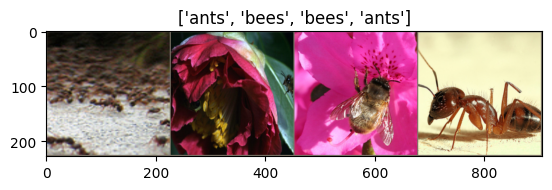

In [6]:
# plot some images
images, classes = next(iter(data_loaders['train'])) # get a batch of data

# make grid from batch
out = torchvision.utils.make_grid(images)

# plot
imshow(out, title=[class_names[i] for i in classes])

# Model Finetune

In [7]:
# load pretrained model from torchvision
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')

# get the number of inputs to the last FC layer
num_input = model.fc.in_features

# replace the last FC layer with our FC layer which classifies 2 classes
model.fc = nn.Linear(num_input, len(class_names))
model = model.to(device)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

11177538

# Train

In [9]:
# training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start_time = time.time()

    # store the best model weights and accuracy (changed while training)
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # each epoch has training and eval phase, set model to respective mode
        for phase in ['train', 'val']:
            if phase == 'train':
                model = model.train()
            else:
                model = model.eval()

            running_loss = 0.0
            running_corrects = 0

            # iterate over the data
            for images, labels in data_loaders[phase]:
                images = images.to(device)
                labels = labels.to(device)

                # reset grad
                optimizer.zero_grad()

                # forward pass, only track gradients during train phase
                with torch.set_grad_enabled(phase == 'train'):
                    # run through model
                    outputs = model(images)

                    # calculate loss
                    loss = criterion(outputs, labels)

                    # get the predicted classes of each sample
                    _, preds = torch.max(outputs, dim=1)

                    # backprop and optimize only during training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # stats of this iteration during this epoch
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # lr step during training
            if phase == 'train':
                scheduler.step()

            # stats for this epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # if this epoch produced better accuracy, track it as best
            if phase == 'val' and epoch_acc > best_acc:
                best_model_weights = copy.deepcopy(model.state_dict())
                best_acc = epoch_acc

        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:4f}')

    # load the best model weights (could be from a previous epoch)
    model.load_state_dict(best_model_weights)

    return model


In [10]:
loss_fn = nn.CrossEntropyLoss() # classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)   # lr decay by factor of 0.1 every 7 epoch 

In [11]:
model = train_model(model, loss_fn, optimizer, lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5800 Acc: 0.6721
val Loss: 0.1964 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5090 Acc: 0.7746
val Loss: 0.2521 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5143 Acc: 0.7869
val Loss: 0.2854 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.4060 Acc: 0.8525
val Loss: 0.2380 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.5318 Acc: 0.8197
val Loss: 0.3030 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.3481 Acc: 0.8525
val Loss: 0.2686 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.3888 Acc: 0.8402
val Loss: 0.4483 Acc: 0.8431

Epoch 7/24
----------
train Loss: 0.3034 Acc: 0.8689
val Loss: 0.1971 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2580 Acc: 0.9098
val Loss: 0.1832 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2533 Acc: 0.9139
val Loss: 0.1714 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2547 Acc: 0.9016
val Loss: 0.1782 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3236 Acc: 0.8607
val Loss: 0.1768 Acc: 0.9281

Ep

In [12]:
# function to display some images and predictions
def visualize_model(mode, num_images=6):
    model.eval()

    images_displayed = 0

    with torch.no_grad():
        for _, (images, labels) in enumerate(data_loaders['val']):
            images = images.to(device)

            # predict
            outputs = model(images)

            # get predicted class
            _, preds = torch.max(outputs, dim=1)

            for i in range(images.size()[0]):
                images_displayed += 1
                ax = plt.subplot(num_images // 2, 2, images_displayed)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[i]]}, Actual: {class_names[labels[i].data]}')
                imshow(images.cpu().data[i])

                if images_displayed == num_images:
                    return

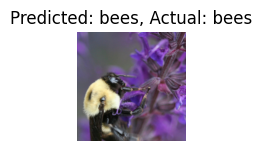

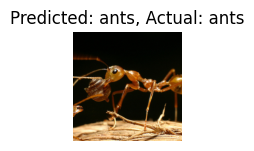

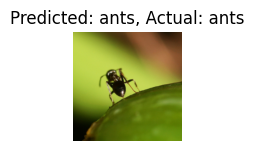

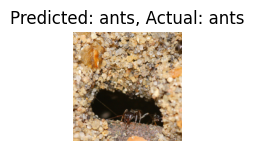

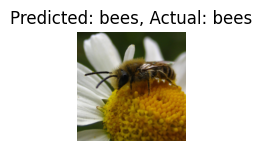

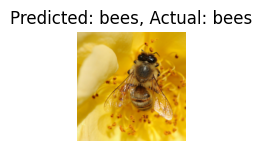

In [13]:
visualize_model(model)

# Model Feature Extractor

In [14]:
# load a pretrained model and freeze all weights, this will only train the last new FC layer which we replace
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
for param in model.parameters():
    param.requires_grad = False

# get the number of inputs to the last FC layer
num_input = model.fc.in_features

# replace the last FC layer with our FC layer which classifies 2 classes
model.fc = nn.Linear(num_input, len(class_names))
model = model.to(device)

count_parameters(model)

1026

In [15]:
loss_fn = nn.CrossEntropyLoss() # classification
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)   # lr decay by factor of 0.1 every 7 epoch 

In [16]:
model = train_model(model, loss_fn, optimizer, lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6970 Acc: 0.7008
val Loss: 0.4068 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.5603 Acc: 0.7500
val Loss: 0.3967 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.4372 Acc: 0.8320
val Loss: 0.3000 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.4087 Acc: 0.8197
val Loss: 0.2043 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3909 Acc: 0.8443
val Loss: 0.1906 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.5062 Acc: 0.7992
val Loss: 0.1855 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4802 Acc: 0.7787
val Loss: 0.2358 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.4210 Acc: 0.8156
val Loss: 0.1852 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3717 Acc: 0.8279
val Loss: 0.1892 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4467 Acc: 0.7910
val Loss: 0.1912 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3010 Acc: 0.8852
val Loss: 0.1650 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3209 Acc: 0.8730
val Loss: 0.1850 Acc: 0.9477

Ep

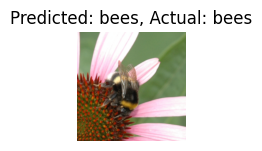

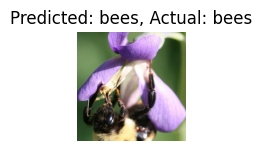

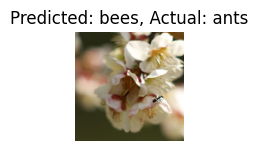

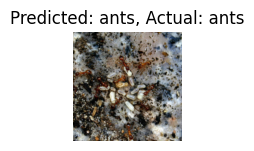

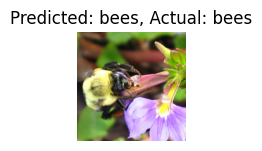

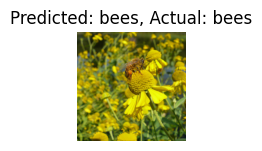

In [17]:
visualize_model(model)